In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam

plt.style.use(["science","bright","grid"])
folder  = "/home/j/j_mens07/phd/data/1_funding_period/current/surrogate_model/"

2025-09-09 11:27:38.768353: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-09 11:27:38.770551: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-09 11:27:38.813507: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-09 11:27:38.833059: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757410058.864464   12652 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757410058.87

### Surrogate Model Data

In [58]:
df  = pd.read_csv(f"{folder}Nx=13_Ny=13_Nz=1_Ne=8.csv")
df

,E0,E1,E2,E3,E4,E5,E6,E7,G,Eq_Jumps,Jumps,Current,Error
0,-0.023736,-0.019085,-0.036212,-0.018558,0.088793,-0.039430,0.009798,0.026165,0.0,100000.0,120000.0,-119.986820,5.326809
1,-0.030736,-0.046848,-0.014108,0.025329,0.084636,0.077305,-0.034326,0.053173,0.0,100000.0,115000.0,-155.947625,6.892665
2,0.012815,-0.062197,-0.005119,-0.062458,0.024989,0.043545,0.088522,-0.056141,0.0,100000.0,40000.0,554.381465,13.908441
3,-0.046470,0.075327,-0.007201,-0.017157,-0.016299,-0.097295,0.010807,0.000609,0.0,100000.0,180000.0,-118.388925,5.505113
4,0.019802,-0.036389,0.089401,0.065631,-0.057430,0.008222,-0.082259,0.072413,0.0,100000.0,75000.0,-566.089043,23.540497
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99355,-0.079231,-0.029659,-0.050398,-0.022507,0.015324,0.023496,-0.056234,-0.069505,0.0,100000.0,30000.0,228.053113,6.518199
99356,-0.042616,0.083276,0.046732,0.060801,-0.033469,0.056400,-0.001344,0.075449,0.0,100000.0,75000.0,-187.093184,6.921112
99357,0.022735,0.075893,0.028571,-0.054248,0.017915,0.013577,0.064401,-0.009849,0.0,100000.0,130000.0,129.088448,5.762623
99358,0.026933,0.041490,-0.066826,0.019517,-0.048332,-0.030042,-0.070934,0.085514,0.0,100000.0,30000.0,-745.299242,19.199141


### Prepare and Split Data

In [59]:
X       = df.iloc[:,:8].values
X       = 2 * (X - X.min()) / (X.max() - X.min()) - 1
y       = df['Current'].values
y_min   = y.min()
y_max   = y.max()
y       = 2 * (y - y.min()) / (y.max() - y.min()) - 1

X_train, X_test, y_train, y_test    = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val      = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [60]:
len(X_train)

71539

### Define Model

In [61]:
# model = Sequential()
# model.add(Dense(64, input_dim=8, activation='tanh'))    # First hidden layer
# model.add(Dense(32, activation='tanh'))                 # Second hidden layer
# model.add(Dense(1, activation='linear'))                # Output layer

model = Sequential()
model.add(Dense(64, input_dim=8))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(32))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(1, activation='linear'))

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',                                 # Monitor validation loss
    patience=10,                                        # Stop after 10 epochs without improvement
    restore_best_weights=True                           # Restore the best model weights
)

/home/j/j_mens07/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/j/j_mens07/.local/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [62]:
# Compile model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5000, batch_size=256, callbacks=[early_stopping])

Epoch 1/5000
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 866us/step - loss: 0.1376 - val_loss: 0.1107
Epoch 2/5000
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 0.1090 - val_loss: 0.0885
Epoch 3/5000
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 0.0869 - val_loss: 0.0709
Epoch 4/5000
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 0.0704 - val_loss: 0.0562
Epoch 5/5000
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 0.0550 - val_loss: 0.0440
Epoch 6/5000
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 0.0430 - val_loss: 0.0340
Epoch 7/5000
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 0.0328 - val_loss: 0.0259
Epoch 8/5000
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 0.0254 - val_loss: 0.0197
Epoch 9/5000
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 0.0192 - val_loss: 0.0152
Epoch 10/5000
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 0.0150 - val_loss: 0.0121
Epoch 11/5000
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 0.0121 - val_loss: 0.0102
Epoch 12

In [64]:
# Evaluate model
loss            = model.evaluate(X_test, y_test)                    # Loss in scaled units
predictions     = model.predict(X_test)
predictions     = (predictions + 1) * (y_max - y_min) / 2 + y_min   # Unscale predictions
y_test_unscaled = (y_test + 1) * (y_max - y_min) / 2 + y_min        # Unscale y_test

# Calculate RMSE in pA
rmse = np.sqrt(mean_squared_error(y_test_unscaled, predictions))
print(f"RMSE: {rmse} pA")

621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 8.4939e-05
621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
RMSE: 12.206800863260247 pA


In [65]:
# Unscale training and validation loss
train_loss_unscaled = np.sqrt(np.array(history.history['loss'])) * (y_max - y_min) / 2
val_loss_unscaled   = np.sqrt(np.array(history.history['val_loss'])) * (y_max - y_min) / 2
residuals           = y_test_unscaled - predictions.flatten()

In [66]:
predictions.flatten()

array([ 2.67123261e+02, -1.95998547e+02,  1.79816596e-02, ...,
        7.53939974e-01, -2.06987250e+02, -7.49929706e+02])

(10, 1000)

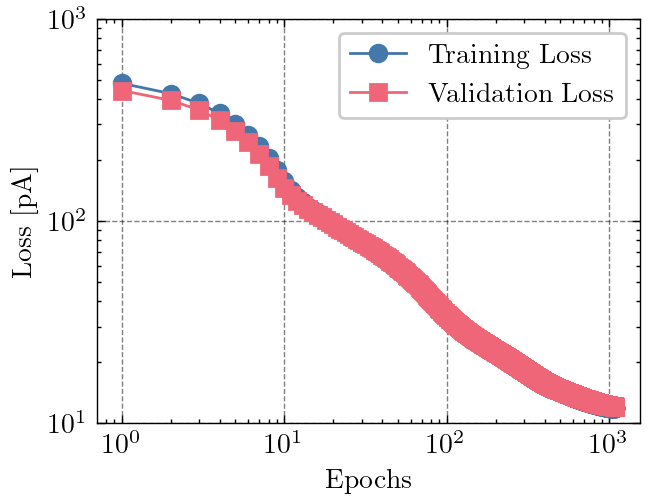

In [70]:
train_loss  = history.history['loss']
val_loss    = history.history['val_loss']
epochs      = range(1, len(train_loss) + 1)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(range(1,len(train_loss_unscaled)+1), train_loss_unscaled, '-o', label='Training Loss')
ax.plot(range(1,len(val_loss_unscaled)+1), val_loss_unscaled, '-s', label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss [pA]')
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(10,1000)
# ax.set_yscale('log')

Text(0, 0.5, 'Predicted Values [pA]')

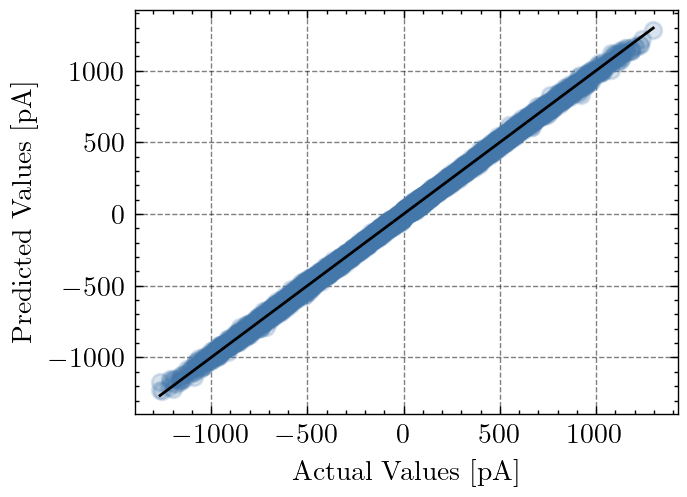

In [54]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.scatter(y_test_unscaled, predictions, alpha=0.2)
ax.plot([y_test_unscaled.min(), y_test_unscaled.max()], [y_test_unscaled.min(), y_test_unscaled.max()], color='black')
ax.set_xlabel('Actual Values [pA]')
ax.set_ylabel('Predicted Values [pA]')

Text(0, 0.5, 'Residuals')

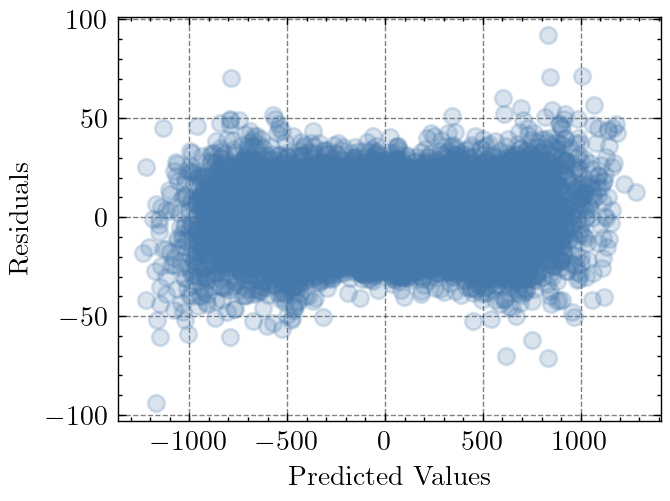

In [55]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.scatter(predictions.flatten(), residuals, alpha=0.2)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')